### Config

In [2]:
import gc
import sys
import warnings
from pathlib import Path
from glob import glob

import os

import ipywidgets as widgets
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import pandas as pd
import polars as pl
import seaborn as sns
warnings.simplefilter("ignore")

from collections import defaultdict, Counter
from functools import partial
import json
import pickle
from pywaffle import Waffle
import squarify
import scipy
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.metrics.pairwise import linear_kernel, cosine_similarity

In [4]:
INPUT_DIR = "../data/input/TMDB/"
OUTPUT_DIR = "../data/output/"

os.makedirs(OUTPUT_DIR, exist_ok=True)

In [6]:
"""
# kaggle APIからdatasetをzip形式でDownload
# zipファイルをINPUT_DIRに解凍するコード
# 初めの一回のみ動かす

import shutil
shutil.unpack_archive(INPUT_DIR+'tmdb-movie-metadata.zip', INPUT_DIR)
"""


### load data and preprocess

In [36]:
credit = pd.read_csv(INPUT_DIR+'tmdb_5000_credits.csv')
movie = pd.read_csv(INPUT_DIR+'tmdb_5000_movies.csv')

In [41]:
credit.columns = ['id', 'title', 'cast', 'crew']
movie_df = movie.merge(credit[['id', 'cast', 'crew']], on='id')
movie_df.head(1)

,budget,genres,homepage,id,keywords,original_language,original_title,overview,popularity,production_companies,...,revenue,runtime,spoken_languages,status,tagline,title,vote_average,vote_count,cast,crew
0,237000000,"[{""id"": 28, ""name"": ""Action""}, {""id"": 12, ""nam...",http://www.avatarmovie.com/,19995,"[{""id"": 1463, ""name"": ""culture clash""}, {""id"":...",en,Avatar,"In the 22nd century, a paraplegic Marine is di...",150.437577,"[{""name"": ""Ingenious Film Partners"", ""id"": 289...",...,2787965087,162.0,"[{""iso_639_1"": ""en"", ""name"": ""English""}, {""iso...",Released,Enter the World of Pandora.,Avatar,7.2,11800,"[{""cast_id"": 242, ""character"": ""Jake Sully"", ""...","[{""credit_id"": ""52fe48009251416c750aca23"", ""de..."


In [43]:
# preprocess
# to datetime
movie_df['release_date'] = pd.to_datetime(movie_df['release_date'])
movie_df['release_year'] = movie_df['release_date'].dt.year
movie_df['release_month'] = movie_df['release_date'].dt.month

In [44]:
# json形式で格納されているcolumnsに対して前処理
json_columns = {'cast', 'crew', 'genres', 'keywords', 'production_countries',
                'production_companies', 'spoken_languages'}

for c in json_columns:
    movie_df[c] = movie_df[c].apply(json.loads)
    if c != "crew":
        movie_df[c] = movie_df[c].apply(lambda row: [x["name"] for x in row])

In [45]:
# create director writer and producer columns
def get_job(job, row):
    person_name = [x['name'] for x in row if x['job']==job]
    return person_name[0] if len(person_name) else np.nan

movie_df["director"] = movie_df["crew"].apply(partial(get_job, "Director"))
movie_df["writer"]   = movie_df["crew"].apply(partial(get_job, "Writer"))
movie_df["producer"] = movie_df["crew"].apply(partial(get_job, "Producer"))

# create profit column
movie_df["profit"] = movie_df["revenue"] - movie_df["budget"]

In [46]:
# 最頻値を用いて欠損値埋め
for col in ['runtime', 'release_year', 'release_month']:
    movie_df[col] = movie_df[col].fillna(movie_df[col].mode().iloc[0])

In [47]:
movie_df.head(1)

,budget,genres,homepage,id,keywords,original_language,original_title,overview,popularity,production_companies,...,vote_average,vote_count,cast,crew,release_year,release_month,director,writer,producer,profit
0,237000000,"[Action, Adventure, Fantasy, Science Fiction]",http://www.avatarmovie.com/,19995,"[culture clash, future, space war, space colon...",en,Avatar,"In the 22nd century, a paraplegic Marine is di...",150.437577,"[Ingenious Film Partners, Twentieth Century Fo...",...,7.2,11800,"[Sam Worthington, Zoe Saldana, Sigourney Weave...","[{'credit_id': '52fe48009251416c750aca23', 'de...",2009.0,12.0,James Cameron,James Cameron,James Cameron,2550965087


### Data Visualization

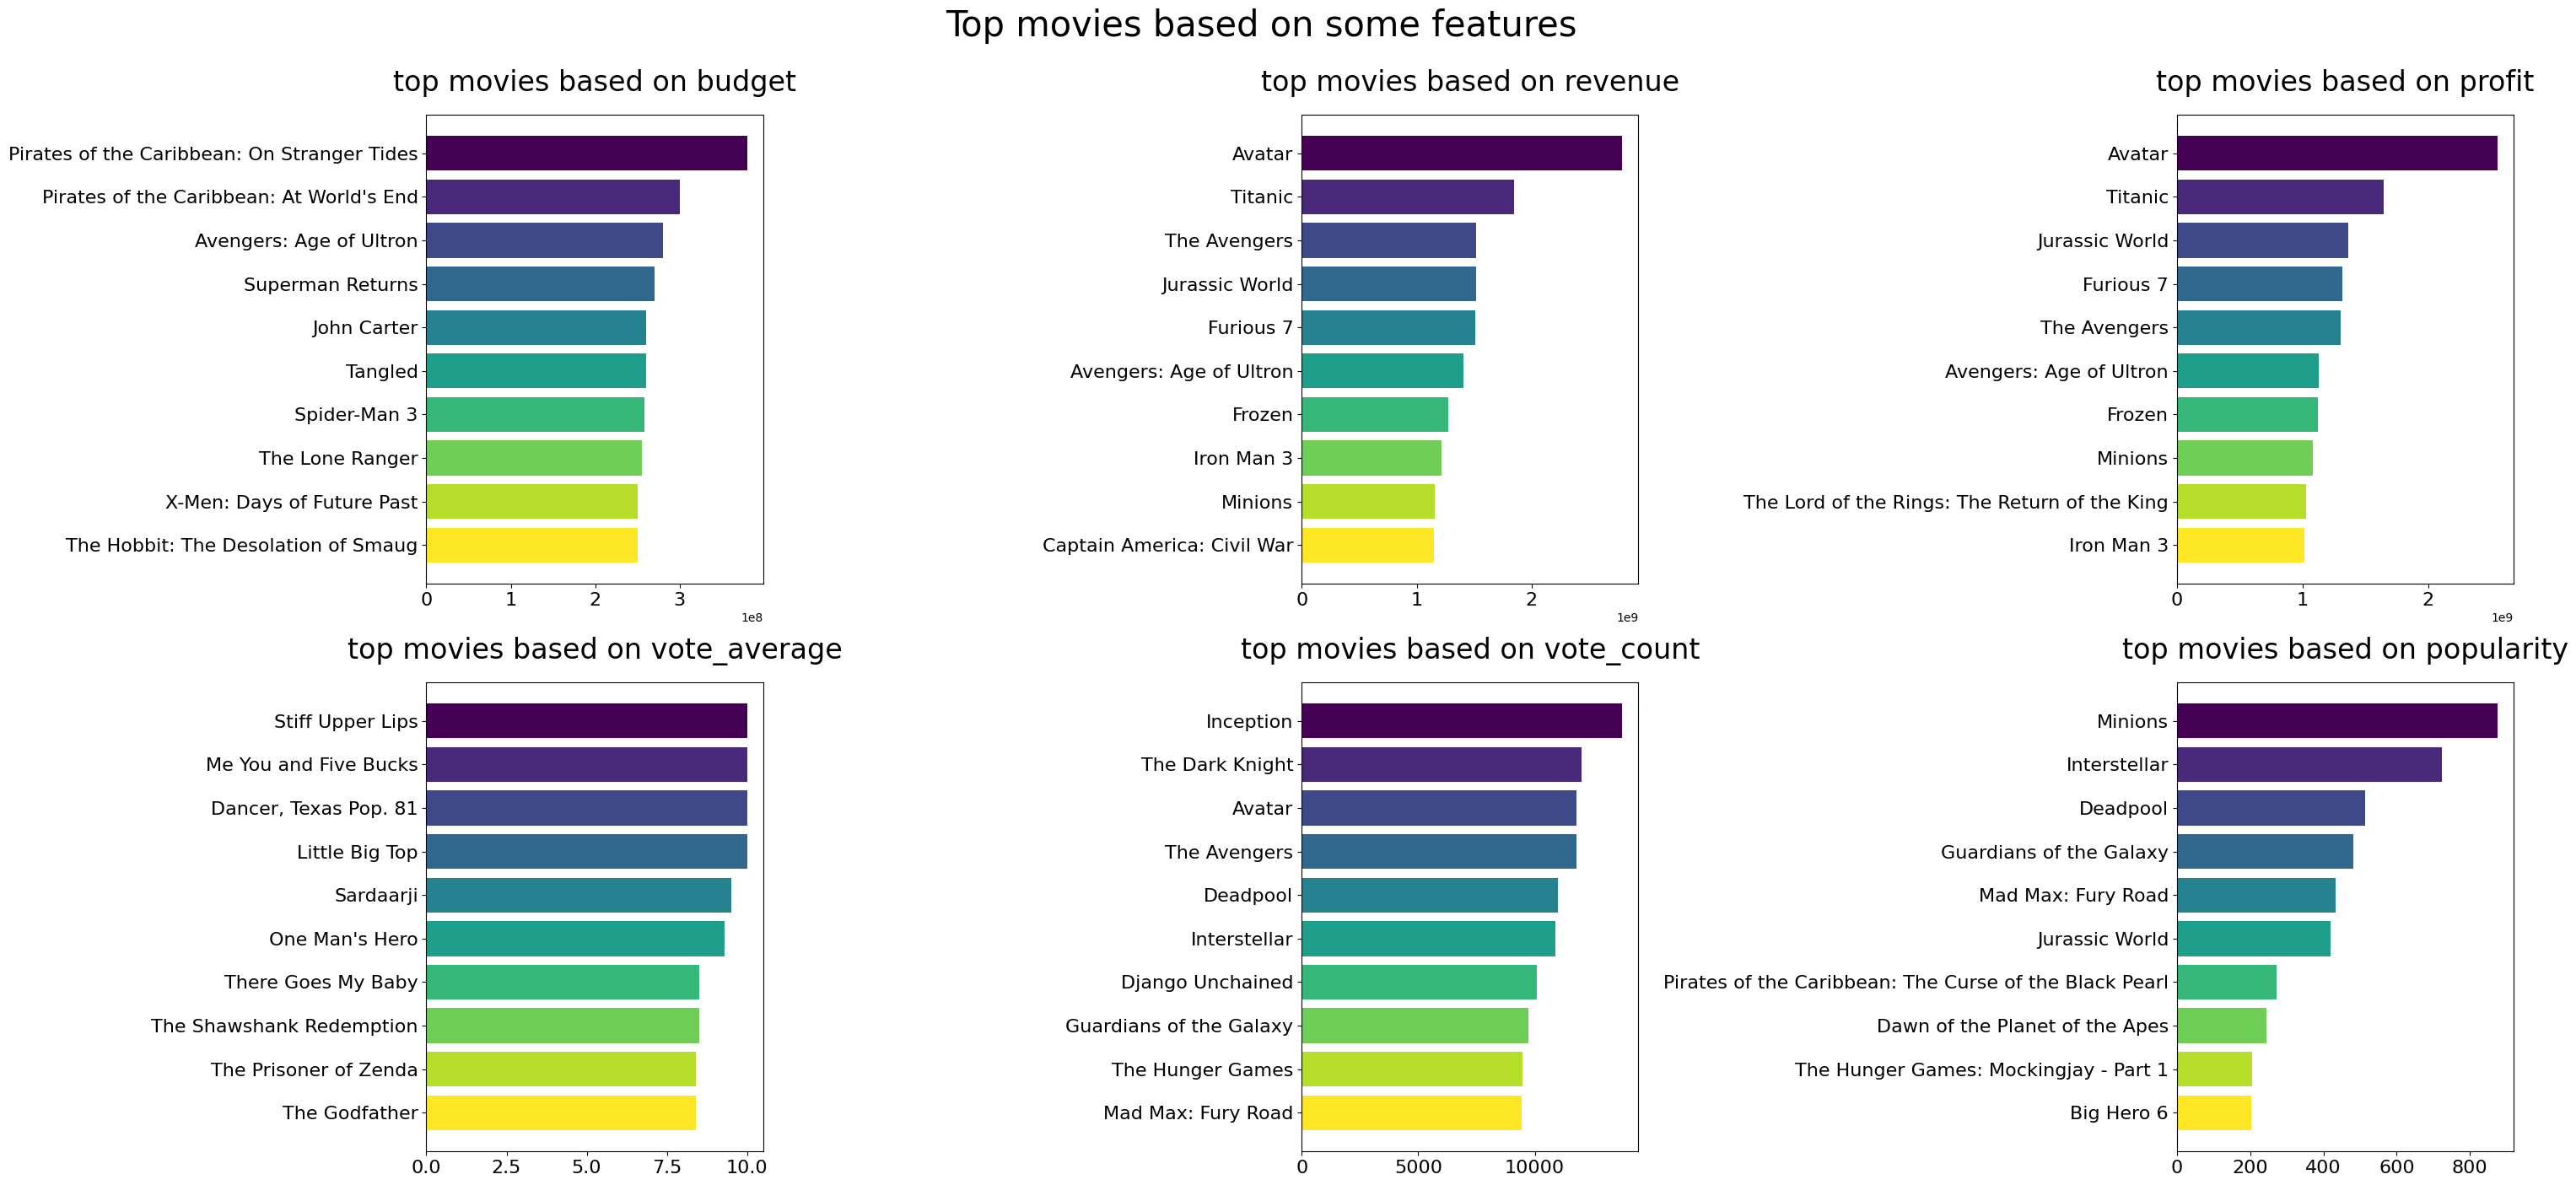

In [49]:
top_movie_num = 10
top_movie_based_on = \
    ['budget', 'revenue', 'profit', 'vote_average', 'vote_count', 'popularity']

fig, ax = plt.subplots(len(top_movie_based_on)//3, 3, figsize=(30, 14))
colors = plt.cm.get_cmap('viridis', top_movie_num)

for i, col in enumerate(top_movie_based_on):
    top_movies_by = movie_df.sort_values(by=[col], ascending=False).head(top_movie_num)
    r, c = i//3, i%3
    ax[r][c].barh(top_movies_by['title'], top_movies_by[col], color=colors.colors)
    ax[r][c].set_title(f'top movies based on {col}', fontsize=24, pad=20)
    ax[r][c].tick_params(axis='both', which='major', labelsize=16)
    ax[r][c].invert_yaxis()

plt.suptitle('Top movies based on some features', fontsize=30, y=1)
fig.tight_layout()